In [1]:
%pip install numpy
%pip install torch
%pip install scikit-image


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from deep_image_prior.utils.denoising_utils import get_noisy_image
from deep_image_prior.utils.common_utils import crop_image, pil_to_np, plot_image_grid, get_image, get_noise, torch_to_np, np_to_torch, get_params, optimize
from deep_image_prior.models import get_net

/home/yungen/jupyter/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
imsize =-1
sigma = 25
sigma_ = sigma/255.
dtype = torch.cuda.FloatTensor

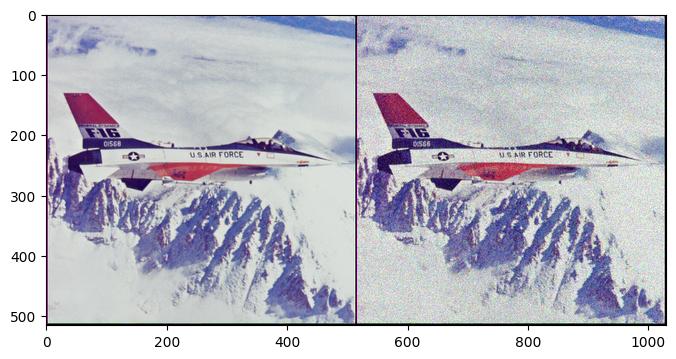

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.70980394, ..., 0.4313349 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.13725491, ..., 0.5319305 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.6018459 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.49803922, ..., 0.25435054,
         0.        , 0.        ],
        [0. 

In [4]:
fname = "data/F16_GT.png"
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

plot_image_grid([img_np, img_noisy_np], 4, 6)

In [5]:
INPUT = "noise"  # 'meshgrid'
pad = "reflection"
OPT_OVER = "net"  # 'net,input'

reg_noise_std = 1.0 / 30.0  # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER = "adam"  # 'LBFGS'
show_every = 500
exp_weight = 0.99

num_iter = 3000
input_depth = 32
figsize = 4
net = get_net(
    input_depth,
    "skip",
    pad,
    skip_n33d=128,
    skip_n33u=128,
    skip_n11=4,
    num_scales=5,
    upsample_mode="bilinear",
).type(dtype)

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

In [6]:
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Starting optimization with ADAM


/home/yungen/jupyter/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


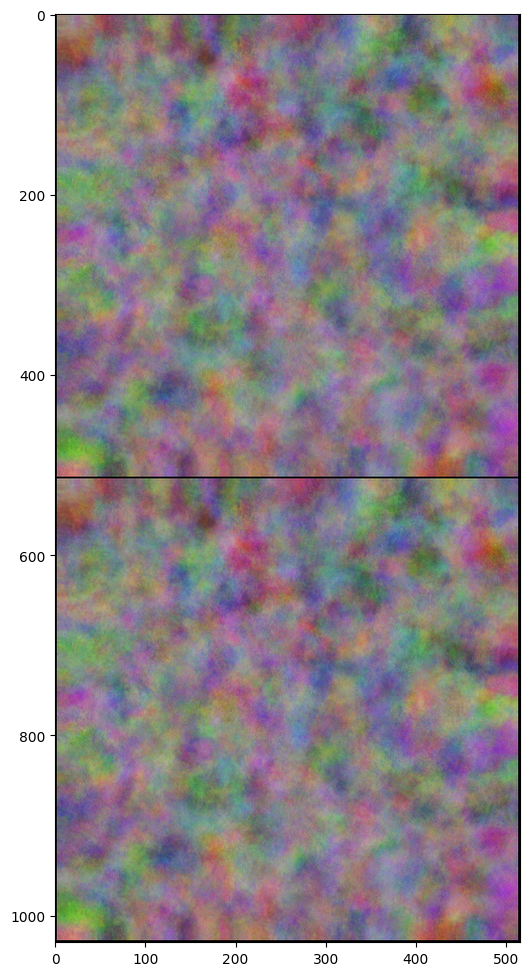

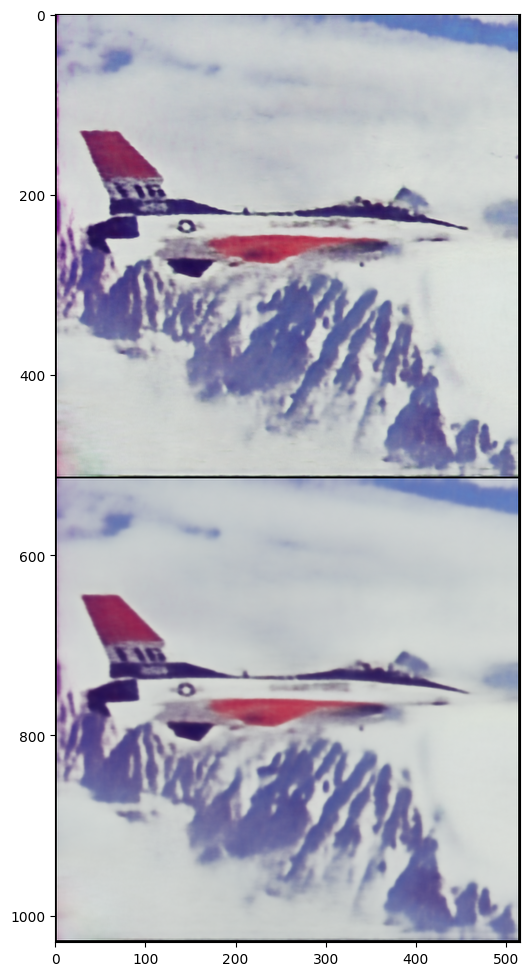

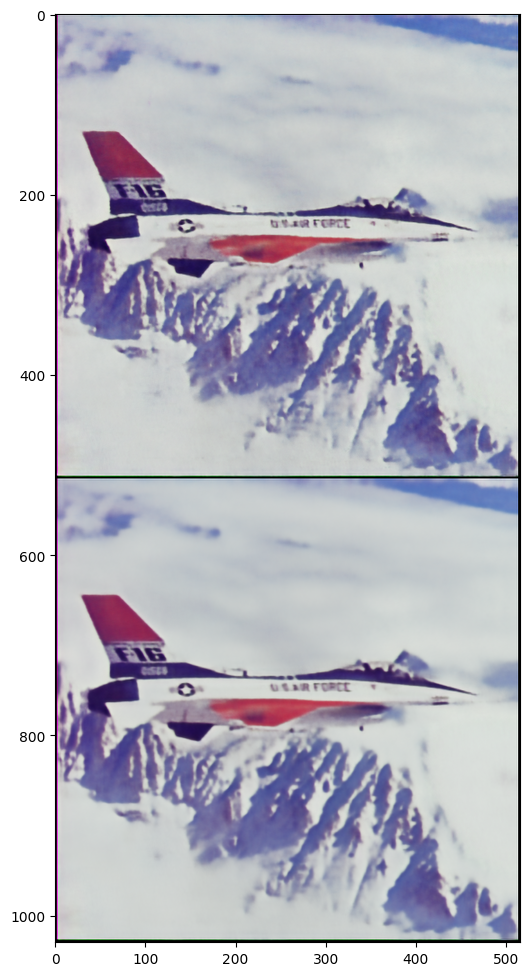

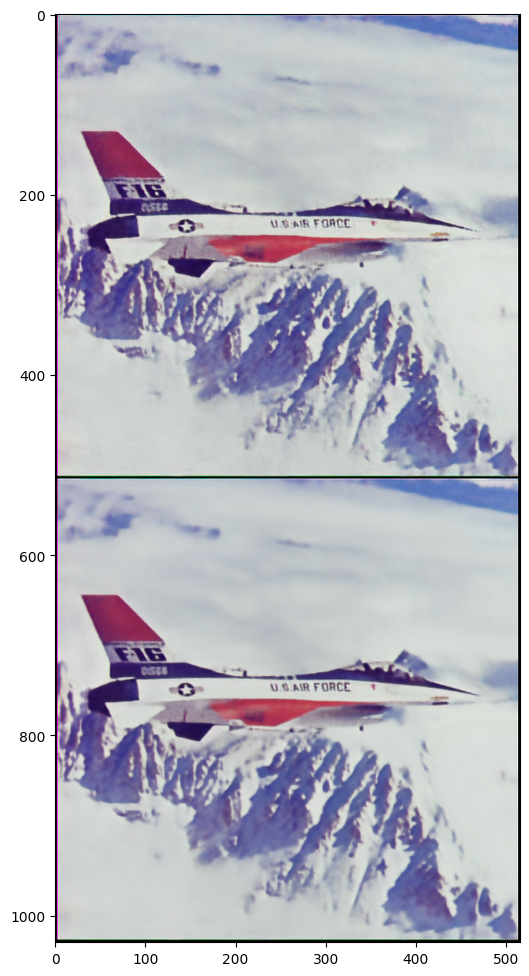

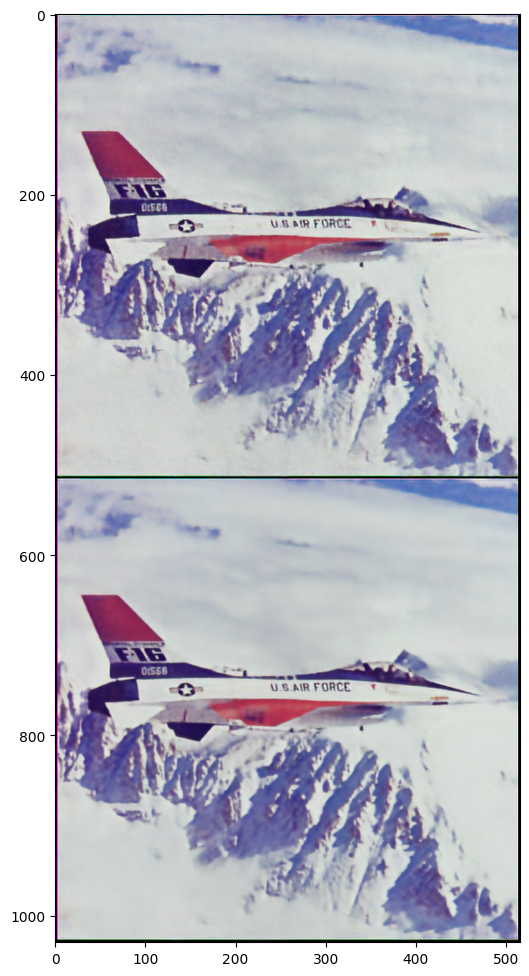

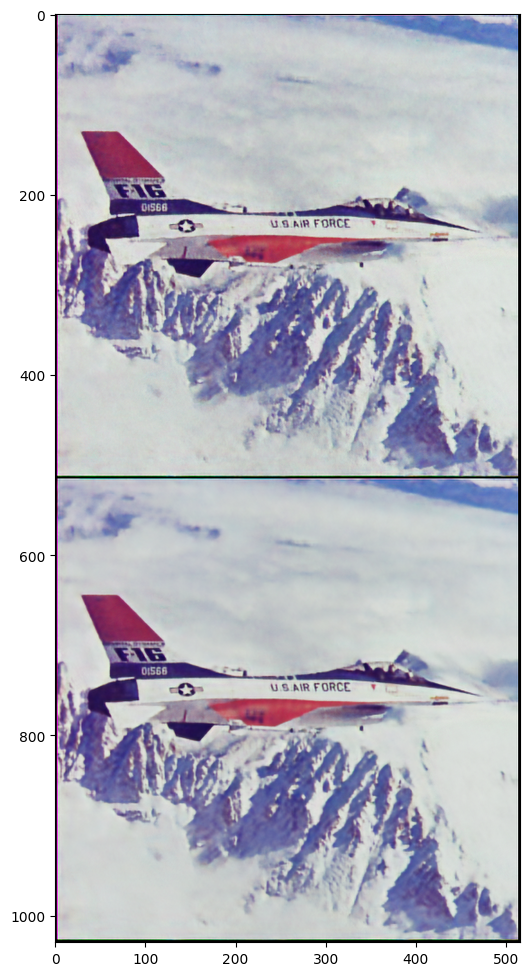

In [7]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

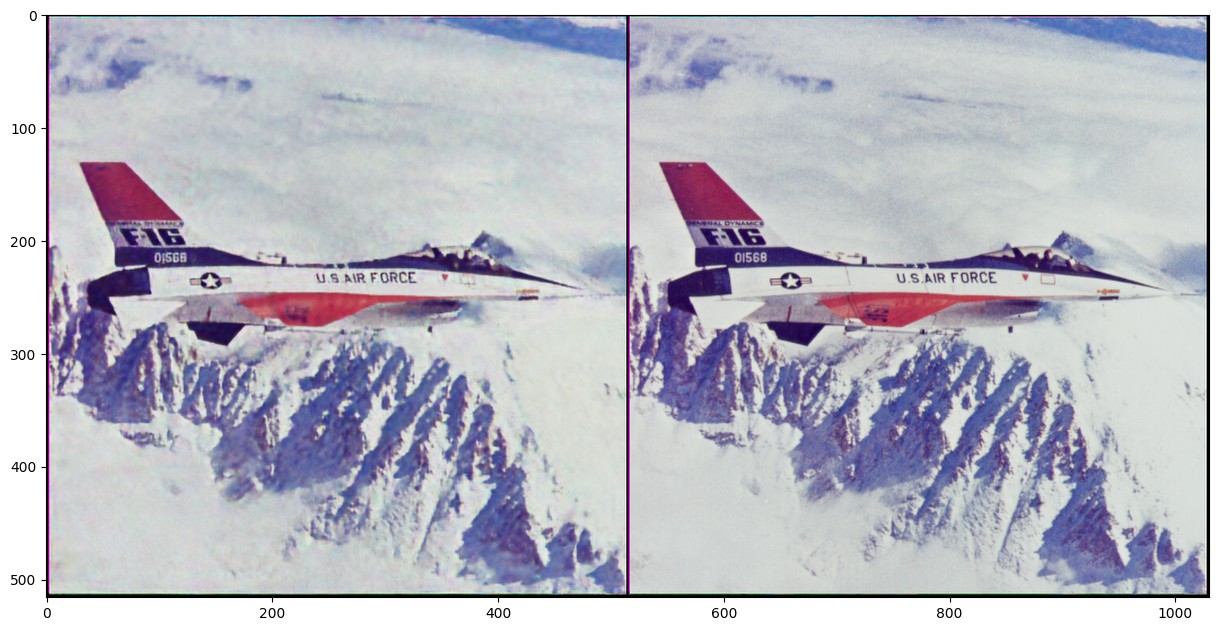

In [8]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);